# Simple MLP using PDB Bind Dataset

In [394]:
import torch
import torch.utils.data
from Bio.PDB import PDBParser
import os
import re
import numpy as np
import matplotlib.pyplot as plt

## Dataset using Protein - Ligand compounds

In [312]:
# Create a list of PDB file paths

pdb_files = []
pdb_ids = []

directory = 'datasets/v2020-other-PL/'

for filename in os.listdir(directory):
    #print(filename)
    f = os.path.join(directory,filename)
    
    files = os.listdir(f)
    pdb_id = files[3][:4]
    
    pdb_files += [(pdb_id, os.path.join(f, files[3]))]

    
# Create the dataset and dataloader
dataset = PDBDataset(pdb_files)

KeyError: '11gs'

## Dataset using Protein - Protein Compounds

In [436]:
directory = 'datasets/PP/'
pdb_files = []
i=0
for filename in os.listdir(directory):
    if i>=50:
        break
    
    #print(filename)
    pdb_files += [(filename, os.path.join(directory, filename))]
    i+=1

## Read the dataset to create the dataloader (adapted to PP)

In [437]:
# Create a dadatasets/PP/s that reads PDB files
class PDBDataset(torch.utils.data.Dataset):
    
    def __init__(self, pdb_files):
        self.pdb_files = pdb_files
        
        parser = PDBParser(QUIET=True)
        self.coordinates = []
        maxlen=0
        self.targets = []
        for pdb_file in pdb_files:
            structure = parser.get_structure(pdb_file[0], pdb_file[1])

            coord = []
            for model in structure:
                for chain in model:
                    for residue in chain:
                        for atom in residue:
                            coord.append(atom.get_coord())
            
            self.targets+=[dictAffinities[pdb_file[0][:4]][1]]
            
            if len(coord)>maxlen:
                maxlen = len(coord)
            self.coordinates += [torch.tensor(coord)]
            
        for i in range(len(self.coordinates)):
            self.coordinates[i] = torch.nn.functional.pad(self.coordinates[i], (0,0,0,maxlen-self.coordinates[i].shape[0]), mode='constant', value=None)
            #coordinates += [coord.clone().detach().requires_grad_(True)]
        print(maxlen)
    
    def __len__(self):
        return len(self.pdb_files)
    
    def __getitem__(self, index):
        
        return torch.flatten(self.coordinates[index].float()),np.float32(self.targets[index])
    

Read the pdb files to create the dataset

In [438]:
dataset = PDBDataset(pdb_files)

24315


create the dataloader

In [439]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [419]:
for i in dataloader:
    print(i)

[tensor([[16.1070, 55.4200, 27.1760,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.3920, -1.9750, 34.6420,  ...,  0.0000,  0.0000,  0.0000],
        [27.7800, 21.6290, 49.3340,  ...,  0.0000,  0.0000,  0.0000]]), tensor([1.0000e-01, 9.0000e-06, 1.2600e+02])]
[tensor([[-27.7290,  72.7030,  97.0880,  ...,   0.0000,   0.0000,   0.0000],
        [ 16.7290,  55.5930,  26.6430,  ...,   0.0000,   0.0000,   0.0000],
        [ -0.4760,  52.6880,  95.6340,  ...,   0.0000,   0.0000,   0.0000]]), tensor([5.1000e-04, 1.0000e-08, 6.0000e-08])]
[tensor([[ 16.7830,  48.8120,  26.4470,  ...,   0.0000,   0.0000,   0.0000],
        [  2.3230, -16.4050,  18.8120,  ...,   0.0000,   0.0000,   0.0000],
        [ 15.6950,  -9.7520,  34.4570,  ...,   0.0000,   0.0000,   0.0000]]), tensor([1.3000e-08, 2.0000e-04, 1.0000e-01])]
[tensor([[ 34.5600,  -3.9220,  31.3010,  ...,   0.0000,   0.0000,   0.0000],
        [105.3140,  50.8220,  41.9510,  ...,   0.0000,   0.0000,   0.0000],
        [ 14.7110,  56.4620,  30.7

In [427]:
dataset.__len__()

31

In [405]:
dataset.__getitem__(5)

(tensor([-8.2730,  9.0020, 47.0870,  ...,  0.0000,  0.0000,  0.0000]), 0.0034)

## Binding affinity for Protein - Ligand Compounds

In [174]:
dictAffinities = {}
with open('datasets/index/INDEX_general_PL.2020', 'r') as f:
    for line in f:
        #print(line)
        if line[0]!='#':

            fields = line.split()

            # Extract the PDB ID and binding affinity value
            pdb_id = fields[0]
            affin = fields[3]
            affinity = re.split('[=<>~]+',affin)
            unity = affinity[1][-2:]
            if unity == 'uM':
                aff=float(affinity[1][:-2])
            elif unity == 'nM':
                aff=float(affinity[1][:-2])*10**(-3)
            elif unity == 'pM':
                aff=float(affinity[1][:-2])*10**(-6)
            elif unity == 'mM':
                aff=float(affinity[1][:-2])*10**(3)
            elif unity == 'fM':
                aff=float(affinity[1][:-2])*10**(-9)
            
            
            #print(f'PDB ID: {pdb_id}, Affinity: {affinity}')
            
            dictAffinities[pdb_id] = [affinity[0],aff]


## Binding affinity for Protein - Protein Compounds

In [320]:
dictAffinities = {}
with open('datasets/index/INDEX_general_PP.2020', 'r') as f:
    for line in f:
        #print(line)
        if line[0]!='#':

            fields = line.split()
            # Extract the PDB ID and binding affinity value
            pdb_id = fields[0]
            affin = fields[3]
            
            affinity = re.split('[=<>~]+',affin)
            unity = affinity[1][-2:]
            if unity == 'uM':
                aff=float(affinity[1][:-2])
            elif unity == 'nM':
                aff=float(affinity[1][:-2])*10**(-3)
            elif unity == 'pM':
                aff=float(affinity[1][:-2])*10**(-6)
            elif unity == 'mM':
                aff=float(affinity[1][:-2])*10**(3)
            elif unity == 'fM':
                aff=float(affinity[1][:-2])*10**(-9)
            
            
            #print(f'PDB ID: {pdb_id1,pdb_id2}, Affinity: {affinity}')
            
            dictAffinities[pdb_id] = [affinity[0],aff]

In [447]:
dictAffinities

{'1fc2': ['Kd', 0.0225],
 '3sgb': ['Kd', 1.7899999999999998e-05],
 '2tgp': ['Kd', 2.4],
 '2ptc': ['Kd', 6.000000000000001e-08],
 '2sni': ['Kd', 2e-06],
 '1atn': ['Kd', 0.00045000000000000004],
 '1gla': ['Kd', 0.18],
 '1acb': ['Kd', 0.0002],
 '2pcc': ['Kd', 1.6],
 '2pcb': ['Kd', 10.0],
 '2sic': ['Kd', 7.12e-05],
 '2cpk': ['Ki', 0.0023],
 '2iff': ['Kd', 0.01],
 '1brs': ['Kd', 1.3e-08],
 '2btf': ['Kd', 2.3],
 '1vfb': ['Kd', 0.0030299999999999997],
 '1hrt': ['Kd', 3e-06],
 '1ppe': ['Kd', 3e-06],
 '2mta': ['Kd', 4.5],
 '1nca': ['Kd', 0.0083],
 '1smf': ['Ki', 0.12],
 '1ihs': ['Ki', 0.0003],
 '1nsn': ['Kd', 0.0001],
 '1bql': ['Kd', 0.1],
 '1nma': ['Kd', 0.014],
 '1mlc': ['Kd', 0.091],
 '1rlb': ['Kd', 0.8],
 '1mah': ['Kd', 2.4999999999999998e-05],
 '1mtn': ['Kd', 0.0095],
 '1tbr': ['Ki', 2e-07],
 '1tbq': ['Ki', 2e-07],
 '1dit': ['Ki', 1e-06],
 '1efn': ['Kd', 0.38],
 '1akj': ['Kd', 126.0],
 '1ak4': ['Kd', 17.0],
 '1gua': ['Kd', 0.04],
 '1ycs': ['Kd', 0.03],
 '1taw': ['Ki', 2e-05],
 '1bth': ['Ki

## Basic MLP

In [434]:
import torch
import torch.nn as nn

In [440]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [441]:
model = MLP(24315*3, 3000, 1)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 30
loss_values = []

In [442]:
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        outputs = model(inputs)
        
        loss = mse_loss(outputs, torch.unsqueeze(targets,-1))
        loss_values.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print('training complete')

training complete


In [443]:
loss_values

[tensor(34.0063, grad_fn=<MseLossBackward0>),
 tensor(2.0150e+12, grad_fn=<MseLossBackward0>),
 tensor(4.8948e+13, grad_fn=<MseLossBackward0>),
 tensor(1.0388e+12, grad_fn=<MseLossBackward0>),
 tensor(1.2130e+12, grad_fn=<MseLossBackward0>),
 tensor(3.9316e+10, grad_fn=<MseLossBackward0>),
 tensor(2.0204e+13, grad_fn=<MseLossBackward0>),
 tensor(2.5576e+11, grad_fn=<MseLossBackward0>),
 tensor(7.6110e+12, grad_fn=<MseLossBackward0>),
 tensor(4.1167e+13, grad_fn=<MseLossBackward0>),
 tensor(5.8603e+14, grad_fn=<MseLossBackward0>),
 tensor(4.5819e+13, grad_fn=<MseLossBackward0>),
 tensor(1.2472e+12, grad_fn=<MseLossBackward0>),
 tensor(6.5984e+12, grad_fn=<MseLossBackward0>),
 tensor(4.5986e+14, grad_fn=<MseLossBackward0>),
 tensor(8.5356e+11, grad_fn=<MseLossBackward0>),
 tensor(1.0877e+12, grad_fn=<MseLossBackward0>),
 tensor(3.2395e+11, grad_fn=<MseLossBackward0>),
 tensor(5.9950e+12, grad_fn=<MseLossBackward0>),
 tensor(4.5577e+13, grad_fn=<MseLossBackward0>),
 tensor(6.4514e+12, gra

Text(0, 0.5, 'training loss')

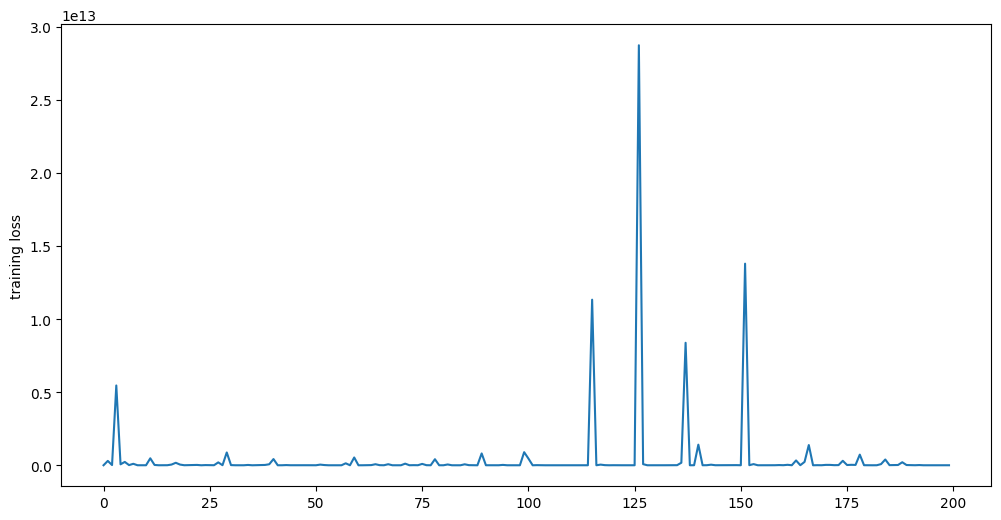

In [446]:
fig, ax1 = plt.subplots(1, figsize=(12, 6), sharex=True)

ax1.plot([i.detach().numpy() for i in loss_values][100:])
ax1.set_ylabel("training loss")